### 1. Importar librerías para abrir coordenadas en archivos de polígonos .shx y .shp:

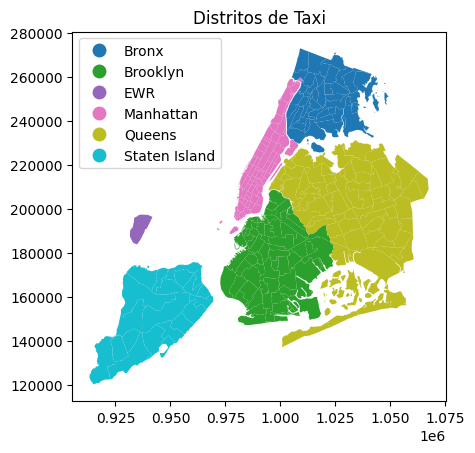

In [437]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# Cargar los datos geoespaciales
data = gpd.read_file('../Datasets/taxi_zones.shx')

# Visualizar los polígonos en un mapa, coloreando cada distrito con un color diferente y moviendo la leyenda a la parte superior
data.plot(column='borough', categorical=True, legend=True, legend_kwds={'loc': 'upper left'})
plt.title('Distritos de Taxi')
plt.show()



Se grafica correctamente los polígonos. A continuación se revisan los datos generados de los archivos:

In [438]:
print(data['geometry'].unique())

<GeometryArray>
[<POLYGON ((933100.918 192536.086, 933091.011 192572.175, 933088.585 192604.9...>,
 <MULTIPOLYGON (((1033269.244 172126.008, 1033439.643 170883.946, 1033473.265...>,
 <POLYGON ((1026308.77 256767.698, 1026495.593 256638.616, 1026567.23 256589....>,
 <POLYGON ((992073.467 203714.076, 992068.667 203711.502, 992061.716 203711.7...>,
 <POLYGON ((935843.31 144283.336, 936046.565 144173.418, 936387.922 143967.75...>,
 <POLYGON ((966568.747 158679.855, 966615.256 158662.292, 966524.882 158822.2...>,
 <POLYGON ((1010804.218 218919.641, 1011049.165 218914.083, 1011117.534 21891...>,
 <POLYGON ((1005482.276 221686.466, 1005304.898 221499.117, 1004958.187 22174...>,
 <POLYGON ((1043803.993 216615.925, 1043849.708 216473.163, 1043900.798 21633...>,
 <POLYGON ((1044355.072 190734.321, 1044612.122 190156.818, 1044849.742 19026...>,
 ...
 <POLYGON ((1025214.477 259577.301, 1025348.099 259365.247, 1025476.99 259153...>,
 <POLYGON ((994849.011 203499.267, 994911.093 203455.62, 994945.49

### 2. Transformar coordenadas planas ATEST WELL-KNOWN IDENTIFIER 2263 a la proyección inversa mundial (EPSG:4326):

In [439]:
gdf = gpd.GeoDataFrame(data)

# Definir EPSG:2263 que está en pies (LATEST WELL-KNOWN IDENTIFIER 2263):
gdf.crs = 'EPSG:2263'

# Corregir coordenadas planas a mundiales:
gdf_latlon = gdf.to_crs('EPSG:4326')  # Proyección inversa al sistema de coordenadas geográficas

# Calcular los centroides de los polígonos
gdf_latlon['centroid'] = gdf_latlon['geometry'].centroid

# Extraer las coordenadas x e y de los centroides
gdf_latlon['centroid_x'] = gdf_latlon['centroid'].x
gdf_latlon['centroid_y'] = gdf_latlon['centroid'].y

# Mostrar el DataFrame con las coordenadas de los centroides
print(gdf_latlon[['centroid_x', 'centroid_y']])

     centroid_x  centroid_y
0    -74.174000   40.691831
1    -73.831299   40.616745
2    -73.847422   40.864474
3    -73.976968   40.723752
4    -74.188484   40.552659
..          ...         ...
258  -73.852215   40.897932
259  -73.906306   40.744235
260  -74.013023   40.709139
261  -73.946510   40.775932
262  -73.951010   40.778766

[263 rows x 2 columns]


C:\Users\davin\AppData\Local\Temp\ipykernel_15572\3284867795.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_latlon['centroid'] = gdf_latlon['geometry'].centroid


In [440]:
gdf_latlon.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry', 'centroid', 'centroid_x', 'centroid_y'],
      dtype='object')

### 3. Ordenar y selecionar columnas:

In [441]:
# Seleccionar las columnas deseadas
gdf_latlon = gdf_latlon[['OBJECTID', 'borough', 'zone', 'centroid_x', 'centroid_y','geometry']]

# Renombrar las columnas centroid_x y centroid_y a longitud y latitud respectivamente
gdf_latlon = gdf_latlon.rename(columns={'OBJECTID':'LocationID','centroid_x': 'longitud', 'centroid_y': 'latitud'})

Observar nuevos datos:

In [442]:
gdf_latlon.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LocationID  263 non-null    int64   
 1   borough     263 non-null    object  
 2   zone        263 non-null    object  
 3   longitud    263 non-null    float64 
 4   latitud     263 non-null    float64 
 5   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 12.5+ KB


### 4. Simplificar polígonos:

In [443]:
from shapely.geometry import shape

# Definir la tolerancia para la simplificación
tolerancia = 0.0001  # ajusta este valor según sea necesario

# Función para simplificar una geometría individual
def simplificar_geometria(geom, tolerancia):
    return geom.simplify(tolerancia)

# Aplicar la función de simplificación a cada geometría en el GeoDataFrame
gdf_latlon['geometry'] = gdf_latlon['geometry'].apply(lambda geom: simplificar_geometria(geom, tolerancia))



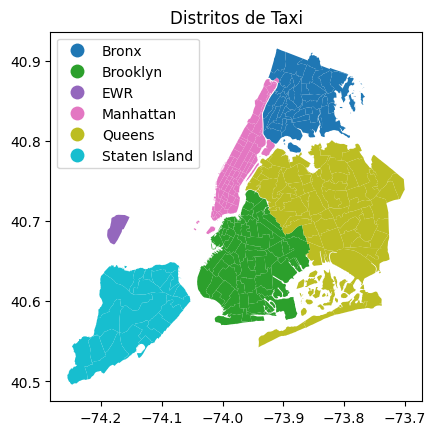

In [444]:
# Visualizar los polígonos en un mapa, coloreando cada distrito con un color diferente y moviendo la leyenda a la parte superior
gdf_latlon.plot(column='borough', categorical=True, legend=True, legend_kwds={'loc': 'upper left'})
plt.title('Distritos de Taxi')
plt.show()

### 5. Exportar datos a CSV para power bi:

In [445]:
gdf_latlon.to_csv('../DataClean/data_mapa_MP.csv',index=False)

Recuento de registros de geometróia no válida

In [446]:
valid_geom = gdf_latlon['geometry'].is_valid

# Mostrar las geometrías que no son válidas
invalid_geom = gdf_latlon[~valid_geom]
print("Geometrías no válidas:")
print(invalid_geom)

# Mostrar la cantidad de geometrías no válidas
print("Cantidad de geometrías no válidas:", len(invalid_geom))


Geometrías no válidas:
Empty GeoDataFrame
Columns: [LocationID, borough, zone, longitud, latitud, geometry]
Index: []
Cantidad de geometrías no válidas: 0


In [447]:
# Encuentra los duplicados en la columna 'LocationID'
duplicados = gdf_latlon[gdf_latlon.duplicated(subset=['LocationID'], keep=False)]

# Muestra los registros duplicados
print(duplicados['LocationID'])

Series([], Name: LocationID, dtype: int64)
